In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/garbage-classifications/val/metal/metal375.jpg
/kaggle/input/garbage-classifications/val/metal/metal374.jpg
/kaggle/input/garbage-classifications/val/metal/metal383.jpg
/kaggle/input/garbage-classifications/val/metal/metal149.jpg
/kaggle/input/garbage-classifications/val/metal/metal8.jpg
/kaggle/input/garbage-classifications/val/metal/metal68.jpg
/kaggle/input/garbage-classifications/val/metal/metal7.jpg
/kaggle/input/garbage-classifications/val/metal/metal6.jpg
/kaggle/input/garbage-classifications/val/metal/metal145.jpg
/kaggle/input/garbage-classifications/val/metal/metal114.jpg
/kaggle/input/garbage-classifications/val/metal/metal154.jpg
/kaggle/input/garbage-classifications/val/metal/metal315.jpg
/kaggle/input/garbage-classifications/val/metal/metal355.jpg
/kaggle/input/garbage-classifications/val/metal/metal403.jpg
/kaggle/input/garbage-classifications/val/metal/metal162.jpg
/kaggle/input/garbage-classifications/val/metal/metal278.jpg
/kaggle/input/garbage-classific

In [2]:
pip install tensorflow numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Directories for training, validation, and test data
train_dir = '/kaggle/input/garbage-classifications/train'
val_dir = '/kaggle/input/garbage-classifications/val'
test_dir = '/kaggle/input/garbage-classifications/test'

# Initialize ImageDataGenerator with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data generators without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load VGG16 model with ImageNet weights, exclude the fully connected top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers initially

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50  # Adjust based on performance
)

# Fine-tune by unfreezing some layers
for layer in base_model.layers[-4:]:  # Unfreeze last few layers
    layer.trainable = True

# Re-compile and further train the model with fine-tuning
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50  # Adjust based on performance
)


Found 2377 images belonging to 6 classes.
Found 806 images belonging to 6 classes.
Found 383 images belonging to 6 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731551654.712024     125 service.cc:145] XLA service 0x7fc75c0015c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731551654.712079     125 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731551654.712083     125 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/75 ━━━━━━━━━━━━━━━━━━━━ 22:49 19s/step - accuracy: 0.1250 - loss: 1.9839

I0000 00:00:1731551667.478845     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 73s 743ms/step - accuracy: 0.3261 - loss: 1.6230 - val_accuracy: 0.5236 - val_loss: 1.2148
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 392ms/step - accuracy: 0.5580 - loss: 1.1764 - val_accuracy: 0.5968 - val_loss: 1.0441
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 397ms/step - accuracy: 0.6172 - loss: 1.0263 - val_accuracy: 0.6538 - val_loss: 0.9407
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 397ms/step - accuracy: 0.6513 - loss: 0.9653 - val_accuracy: 0.7047 - val_loss: 0.8452
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 401ms/step - accuracy: 0.7054 - loss: 0.8633 - val_accuracy: 0.6861 - val_loss: 0.8254
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 396ms/step - accuracy: 0.6848 - loss: 0.8649 - val_accuracy: 0.7134 - val_loss: 0.7828
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 399ms/step - accuracy: 0.6960 - loss: 0.8152 - val_accuracy: 0.6985 - val_loss: 0.8340
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 399ms/step - accuracy: 0.6936 - loss: 0.8283 - val_accuracy: 0.717

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step 


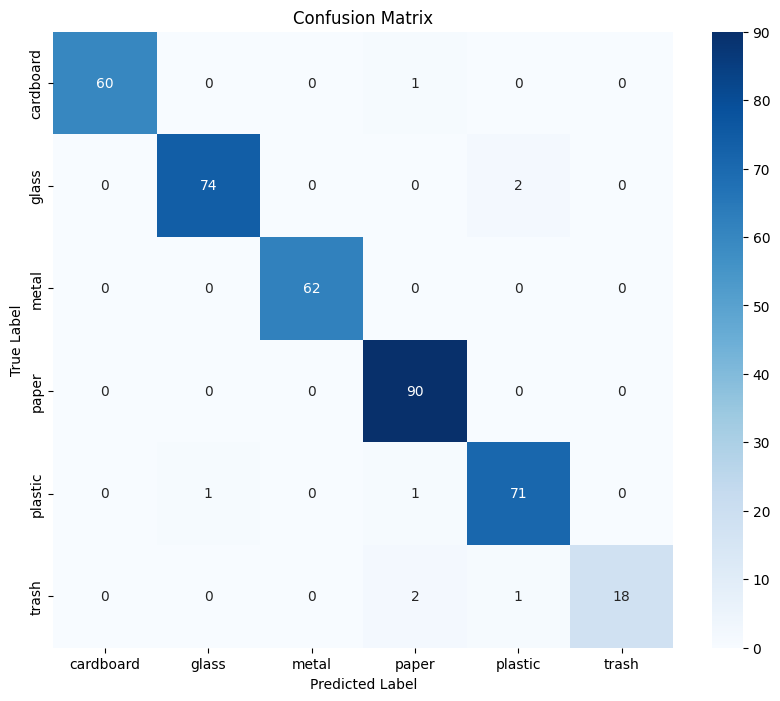

              precision    recall  f1-score   support

   cardboard       1.00      0.98      0.99        61
       glass       0.99      0.97      0.98        76
       metal       1.00      1.00      1.00        62
       paper       0.96      1.00      0.98        90
     plastic       0.96      0.97      0.97        73
       trash       1.00      0.86      0.92        21

    accuracy                           0.98       383
   macro avg       0.98      0.96      0.97       383
weighted avg       0.98      0.98      0.98       383



In [4]:
# Predict on the test data
test_predictions = model.predict(test_generator)
y_pred = np.argmax(test_predictions, axis=1)
y_true = test_generator.classes  # True labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


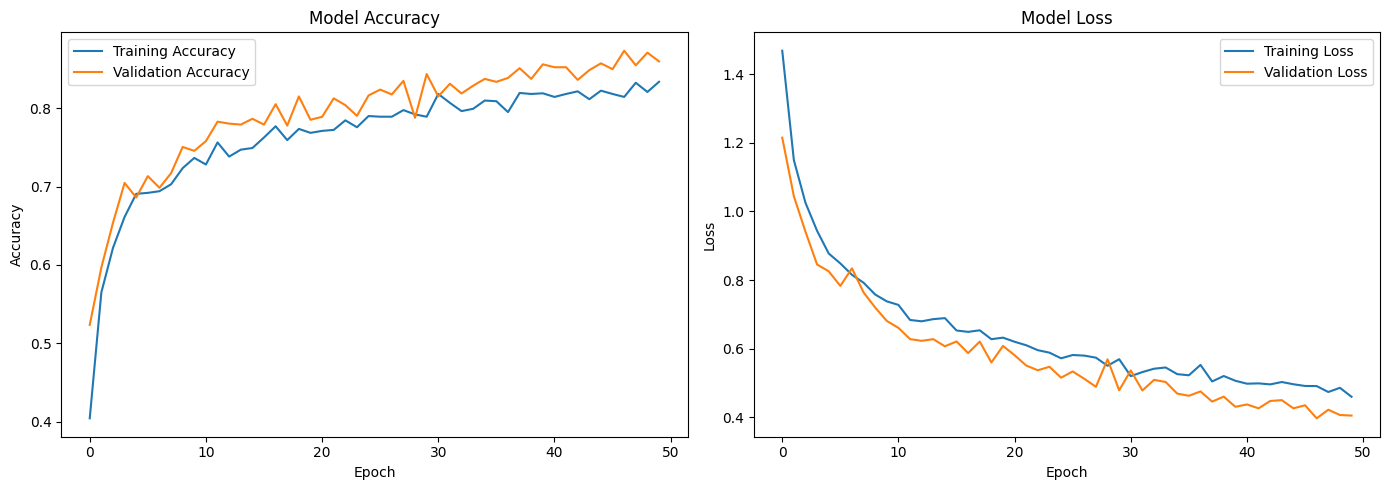

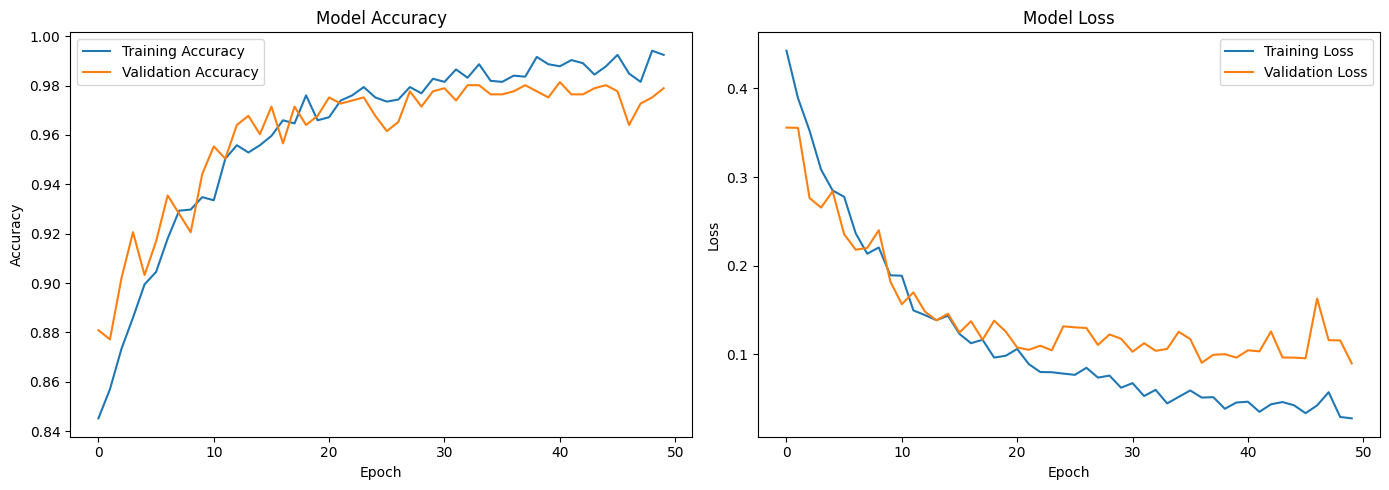

In [5]:
# Plot training and validation accuracy and loss over epochs
def plot_training_history(history):
    epochs = range(len(history.history['accuracy']))

    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Plot for initial training
plot_training_history(history)

# Plot for fine-tuning phase
plot_training_history(history_finetune)


In [6]:
# Calculate the final training accuracy in percentage
final_train_accuracy = history.history['accuracy'][-1] * 100
print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")

# Calculate the final validation accuracy in percentage
final_val_accuracy = history.history['val_accuracy'][-1] * 100
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

# Evaluate the model on test data and calculate test accuracy in percentage
test_loss, test_accuracy = model.evaluate(test_generator)
final_test_accuracy = test_accuracy * 100
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")


Final Training Accuracy: 83.38%
Final Validation Accuracy: 85.98%
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.9815 - loss: 0.0656
Final Test Accuracy: 97.91%


In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Specify your test directory
test_dir = '/kaggle/input/garbage-classifications/test'

# Class labels (must match the order in training)
class_labels = list(train_generator.class_indices.keys())

# Initialize counters for correct and total predictions
correct_predictions = 0
total_images = 0

# Loop through each class directory
for class_label in class_labels:
    class_dir = os.path.join(test_dir, class_label)
    if os.path.exists(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Load and preprocess the image
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)

                # Make a prediction
                predictions = model.predict(img_array)
                predicted_class = np.argmax(predictions, axis=1)[0]
                predicted_label = class_labels[predicted_class]
                
                # Count correct predictions
                if predicted_label == class_label:
                    correct_predictions += 1
                total_images += 1

                # Print the predicted label
                print(f"Image: {img_name}, True Class: {class_label}, Predicted Class: {predicted_label}")

# Calculate and print the accuracy
test_accuracy = (correct_predictions / total_images) * 100
print(f"\nTest Accuracy: {test_accuracy:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: cardboard403.jpg, True Class: cardboard, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: cardboard132.jpg, True Class: cardboard, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: cardboard3.jpg, True Class: cardboard, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: cardboard92.jpg, True Class: cardboard, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: cardboard306.jpg, True Class: cardboard, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: cardboard89.jpg, True Class: cardboard, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: cardboard320.jpg, True Class: cardboard, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: cardboard248.jpg, True Class: cardboard, Predicted Class: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: cardboard148.jpg, True Class: cardboard, Predicted Class:

In [11]:
model.save("model/vgg16_model.h5")  # SavedModel format


In [14]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model('/kaggle/working/model/vgg16_model.h5')  # Make sure this path is correct


In [15]:
import zipfile

# Define the path to your model file and the output ZIP file name
model_file_path = '/kaggle/working/model/vgg16_model.h5'
zip_file_path = '/kaggle/working/vgg16_model.zip'

# Create the ZIP file and add the .h5 model
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    zipf.write(model_file_path, arcname='vgg16_model.h5')

print("Model file zipped successfully!")


Model file zipped successfully!
